# Local Outlier Factor (LOF) for Anomaly Detection

**Мета:** Виявлення локальних аномалій, які Isolation Forest може пропустити.

**LOF (Local Outlier Factor):**
- Порівнює локальну щільність точки з її сусідами
- Точки з нижчою щільністю ніж сусіди — аномалії
- Виявляє **локальні** outliers (нетипові для свого "сусідства")
- Memory-intensive: O(n²) — потребує sampling для великих даних

**IF vs LOF:**
- **Isolation Forest** → глобальні outliers (екстремальні значення)
- **LOF** → локальні outliers (нетипові для своєї групи)

**Pipeline:**
1. Rule-based (Red Flags) ✓
2. Statistical Screens ✓
3. Isolation Forest ✓
4. **LOF** ← current
5. Ensemble

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from src.data_loader import load_tenders, load_bids, load_buyers, load_suppliers, memory_usage
from src.detectors.ml_based import IsolationForestDetector, LOFDetector

# ============================================================
# CONFIGURATION
# ============================================================
YEARS = [2022, 2023, 2024, 2025]  # Full dataset
CONTAMINATION = 0.05  # Expected 5% anomalies
LOF_SAMPLE_SIZE = 1_000_000  # LOF is memory-intensive (adjust based on RAM)
LOF_N_NEIGHBORS = 20
# ============================================================

# Create output directories
Path('../results/figures/lof').mkdir(parents=True, exist_ok=True)

# Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

RISK_COLORS = {'critical': '#d62728', 'high': '#ff7f0e', 'medium': '#ffbb78', 'low': '#2ca02c'}

print(f"Configuration:")
print(f"  YEARS = {YEARS}")
print(f"  CONTAMINATION = {CONTAMINATION}")
print(f"  LOF_SAMPLE_SIZE = {LOF_SAMPLE_SIZE:,}")
print(f"  LOF_N_NEIGHBORS = {LOF_N_NEIGHBORS}")

Configuration:
  YEARS = [2022, 2023, 2024, 2025]
  CONTAMINATION = 0.05
  LOF_SAMPLE_SIZE = 1,000,000
  LOF_N_NEIGHBORS = 20


## 1. Завантаження даних

In [2]:
print(f"Loading data for years: {YEARS}...")
tenders = load_tenders(years=YEARS)
buyers = load_buyers()
suppliers = load_suppliers()

print(f"\nDataset size:")
print(f"  Tenders: {len(tenders):,}")
print(f"  Buyers: {len(buyers):,}")
print(f"  Suppliers: {len(suppliers):,}")
print(f"  Memory: {memory_usage(tenders)}")

Loading data for years: [2022, 2023, 2024, 2025]...
Loaded 2022: 2,385,398 records
Loaded 2023: 3,491,748 records
Loaded 2024: 3,389,960 records
Loaded 2025: 3,610,854 records
Loaded buyers: 35,995
Loaded suppliers: 358,376

Dataset size:
  Tenders: 12,877,960
  Buyers: 35,995
  Suppliers: 358,376
  Memory: 10.73 GB


In [3]:
# ============================================================
# EXTENDED FEATURE ENGINEERING (same as IF notebook)
# ============================================================

print("Computing extended features on full dataset...")

# --- 1. Benchmark features (price vs CPV median) ---
cpv_stats = tenders.groupby('main_cpv_2_digit').agg({
    'tender_value': 'median',
    'award_value': 'median',
    'number_of_tenderers': 'mean',
}).rename(columns={
    'tender_value': 'cpv_median_value',
    'award_value': 'cpv_median_award',
    'number_of_tenderers': 'cpv_avg_tenderers',
})

tenders = tenders.merge(cpv_stats, on='main_cpv_2_digit', how='left')

# Compute relative features
tenders['price_vs_cpv_median'] = tenders['award_value'] / tenders['cpv_median_award'].replace(0, np.nan)
tenders['tenderers_vs_cpv_avg'] = tenders['number_of_tenderers'] / tenders['cpv_avg_tenderers'].replace(0, np.nan)

print(f"  Added benchmark features: price_vs_cpv_median, tenderers_vs_cpv_avg")

# --- 2. Pair features (buyer-supplier relationship) ---
pair_stats = tenders.groupby(['buyer_id', 'supplier_id']).agg({
    'tender_id': 'count',
    'award_value': 'sum'
}).rename(columns={'tender_id': 'pair_contract_count', 'award_value': 'pair_total_value'})

buyer_total = tenders.groupby('buyer_id')['award_value'].sum()
pair_stats = pair_stats.reset_index()
pair_stats = pair_stats.merge(buyer_total.rename('buyer_total_value'), on='buyer_id')
pair_stats['pair_share_of_buyer'] = pair_stats['pair_total_value'] / pair_stats['buyer_total_value'].replace(0, np.nan)

tenders = tenders.merge(
    pair_stats[['buyer_id', 'supplier_id', 'pair_contract_count', 'pair_share_of_buyer']],
    on=['buyer_id', 'supplier_id'],
    how='left'
)

print(f"  Added pair features: pair_contract_count, pair_share_of_buyer")

# --- 3. Log-transform value features ---
tenders['log_tender_value'] = np.log1p(tenders['tender_value'])
print(f"  Added log-transformed: log_tender_value")

print(f"\nFeature engineering complete.")

# --- 4. Sample AFTER feature engineering ---
print(f"\nSampling {LOF_SAMPLE_SIZE:,} tenders for LOF analysis...")
tenders_sample = tenders.sample(LOF_SAMPLE_SIZE, random_state=42)
print(f"Sample size: {len(tenders_sample):,} ({len(tenders_sample)/len(tenders)*100:.1f}% of full dataset)")

Computing extended features on full dataset...
  Added benchmark features: price_vs_cpv_median, tenderers_vs_cpv_avg
The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.
  Added pair features: pair_contract_count, pair_share_of_buyer
  Added log-transformed: log_tender_value

Feature engineering complete.

Sampling 1,000,000 tenders for LOF analysis...
Sample size: 1,000,000 (7.8% of full dataset)


## 2. Extended Feature Configuration (same as IF)

In [4]:
# EXTENDED feature configuration (SAME as IF notebook - 19 features)
features_extended = {
    "tender": [
        # Value features
        "tender_value",
        "price_change_pct",
        "number_of_tenderers",
        "is_single_bidder",
        "is_competitive",
        # Log-transformed
        "log_tender_value",
        # Benchmark (vs CPV median)
        "price_vs_cpv_median",
        "tenderers_vs_cpv_avg",
        # Pair features (buyer-supplier relationship)
        "pair_contract_count",
        "pair_share_of_buyer",
        # Temporal
        "is_weekend",
        "is_q4",
        "is_december",
    ],
    "buyer": [
        "single_bidder_rate",
        "competitive_rate",
        "avg_discount_pct",
        "supplier_diversity_index",
    ],
    "supplier": [
        "total_awards",
        "total_value",
    ],
}

total_features = sum(len(v) for v in features_extended.values())
print(f"Extended feature set: {total_features} features (same as IF)")
for category, feats in features_extended.items():
    print(f"  {category}: {len(feats)} - {feats}")

Extended feature set: 19 features (same as IF)
  tender: 13 - ['tender_value', 'price_change_pct', 'number_of_tenderers', 'is_single_bidder', 'is_competitive', 'log_tender_value', 'price_vs_cpv_median', 'tenderers_vs_cpv_avg', 'pair_contract_count', 'pair_share_of_buyer', 'is_weekend', 'is_q4', 'is_december']
  buyer: 4 - ['single_bidder_rate', 'competitive_rate', 'avg_discount_pct', 'supplier_diversity_index']
  supplier: 2 - ['total_awards', 'total_value']


## 3. LOF Detection

In [5]:
# Initialize LOF detector with EXTENDED features
lof_detector = LOFDetector(
    n_neighbors=LOF_N_NEIGHBORS,
    contamination=CONTAMINATION,
    features=features_extended,
)

# Run detection
print(f"Running LOF with {total_features} extended features...")
lof_results = lof_detector.fit_detect(
    tenders_sample,
    buyers_df=buyers,
    suppliers_df=suppliers,
)

Running LOF with 19 extended features...
Processing 1,000,000 tenders...
Fitting LOF...
LOF complete! Anomalies: 50,000 (5.00%)


C:\Users\kachm\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


In [6]:
# Summary
print("LOF Results:")
print(lof_detector.summary().to_string(index=False))

print(f"\nFeatures used: {lof_detector.feature_names_}")

LOF Results:
risk_level  count  percentage
  critical      1      0.0001
      high      0      0.0000
    medium      1      0.0001
       low 999988     99.9988

Features used: ['tender_value', 'price_change_pct', 'number_of_tenderers', 'is_single_bidder', 'is_competitive', 'log_tender_value', 'price_vs_cpv_median', 'tenderers_vs_cpv_avg', 'pair_contract_count', 'pair_share_of_buyer', 'is_weekend', 'is_q4', 'is_december', 'single_bidder_rate', 'competitive_rate', 'avg_discount_pct', 'supplier_diversity_index', 'total_awards', 'total_value']


## 4. Isolation Forest (for comparison)

In [7]:
# Run IF on same sample with SAME extended features for fair comparison
if_detector = IsolationForestDetector(
    contamination=CONTAMINATION,
    n_estimators=100,
    random_state=42,
    features=features_extended,
)

print(f"Running Isolation Forest on same sample with {total_features} features...")
if_results = if_detector.fit_detect(
    tenders_sample,
    buyers_df=buyers,
    suppliers_df=suppliers,
)

Running Isolation Forest on same sample with 19 features...
Processing 1,000,000 tenders...
Step 1/4: Preparing features...
  Features: 19
Step 2/4: Preprocessing (impute + scale)...
  Shape: (1000000, 19)
Step 3/4: Fitting Isolation Forest...
Step 4/4: Computing results...

Isolation Forest complete!
  Anomalies detected: 50,000 (5.00%)


## 5. LOF vs IF Comparison

In [8]:
# Merge results
comparison = if_results.merge(lof_results, on='tender_id')

# Agreement matrix
both_anomaly = ((comparison['if_anomaly'] == 1) & (comparison['lof_anomaly'] == 1)).sum()
only_if = ((comparison['if_anomaly'] == 1) & (comparison['lof_anomaly'] == 0)).sum()
only_lof = ((comparison['if_anomaly'] == 0) & (comparison['lof_anomaly'] == 1)).sum()
neither = ((comparison['if_anomaly'] == 0) & (comparison['lof_anomaly'] == 0)).sum()

print("AGREEMENT MATRIX:")
print(f"                    LOF Normal    LOF Anomaly")
print(f"IF Normal           {neither:>10,}    {only_lof:>10,}")
print(f"IF Anomaly          {only_if:>10,}    {both_anomaly:>10,}")

# Metrics
score_corr = comparison['if_score'].corr(comparison['lof_score'])
if_set = set(comparison[comparison['if_anomaly'] == 1]['tender_id'])
lof_set = set(comparison[comparison['lof_anomaly'] == 1]['tender_id'])
jaccard = len(if_set & lof_set) / len(if_set | lof_set) if len(if_set | lof_set) > 0 else 0

print(f"\nMETRICS:")
print(f"  Score correlation: {score_corr:.3f}")
print(f"  Jaccard similarity: {jaccard:.3f}")
print(f"  Overlap: {both_anomaly:,} ({both_anomaly/len(comparison)*100:.2f}%)")

AGREEMENT MATRIX:
                    LOF Normal    LOF Anomaly
IF Normal              905,760        44,240
IF Anomaly              44,240         5,760

METRICS:
  Score correlation: 0.015
  Jaccard similarity: 0.061
  Overlap: 5,760 (0.58%)


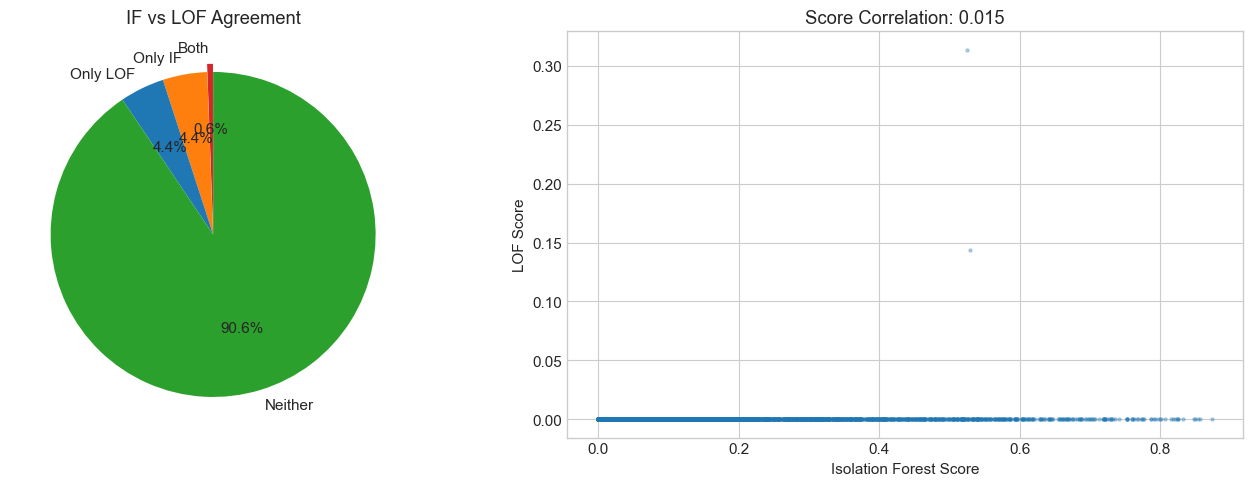

In [9]:
# Visualize agreement
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Agreement pie chart
labels = ['Both', 'Only IF', 'Only LOF', 'Neither']
sizes = [both_anomaly, only_if, only_lof, neither]
colors = ['#d62728', '#ff7f0e', '#1f77b4', '#2ca02c']
explode = (0.05, 0, 0, 0)

axes[0].pie(sizes, explode=explode, labels=labels, colors=colors,
            autopct='%1.1f%%', startangle=90)
axes[0].set_title('IF vs LOF Agreement')

# Score scatter
sample_viz = comparison.sample(min(5000, len(comparison)), random_state=42)
axes[1].scatter(sample_viz['if_score'], sample_viz['lof_score'], alpha=0.3, s=5)
axes[1].set_xlabel('Isolation Forest Score')
axes[1].set_ylabel('LOF Score')
axes[1].set_title(f'Score Correlation: {score_corr:.3f}')

plt.tight_layout()
plt.savefig('../results/figures/lof/if_lof_agreement.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Характеристики виявлених аномалій

In [10]:
# Merge tender info
analysis_df = tenders_sample.merge(comparison[['tender_id', 'if_anomaly', 'lof_anomaly', 'if_score', 'lof_score']], on='tender_id')

# Create categories
def categorize(row):
    if row['if_anomaly'] == 1 and row['lof_anomaly'] == 1:
        return 'Both'
    elif row['if_anomaly'] == 1:
        return 'Only IF'
    elif row['lof_anomaly'] == 1:
        return 'Only LOF'
    else:
        return 'Normal'

analysis_df['category'] = analysis_df.apply(categorize, axis=1)

# Statistics by category
stats = analysis_df.groupby('category').agg({
    'tender_id': 'count',
    'tender_value': ['mean', 'median'],
    'price_change_pct': 'mean',
    'number_of_tenderers': 'mean',
    'is_single_bidder': 'mean',
    'is_competitive': 'mean',
}).round(2)

stats.columns = ['count', 'mean_value', 'median_value', 'mean_discount', 'mean_tenderers', 'single_bidder_rate', 'competitive_rate']
stats['single_bidder_rate'] = (stats['single_bidder_rate'] * 100).round(1)
stats['competitive_rate'] = (stats['competitive_rate'] * 100).round(1)

print("CHARACTERISTICS BY CATEGORY:")
print(stats.to_string())

CHARACTERISTICS BY CATEGORY:
           count   mean_value  median_value  mean_discount  mean_tenderers  single_bidder_rate  competitive_rate
category                                                                                                        
Both        5760  12212395.17      257150.0          10.03            2.39                28.0              39.0
Normal    905760     54600.06        4392.0           0.48            0.09                 3.0               2.0
Only IF    44240   3126184.71      348000.0          12.53            2.48                33.0              52.0
Only LOF   44240     61735.61        8500.0           0.56            0.12                 6.0               2.0


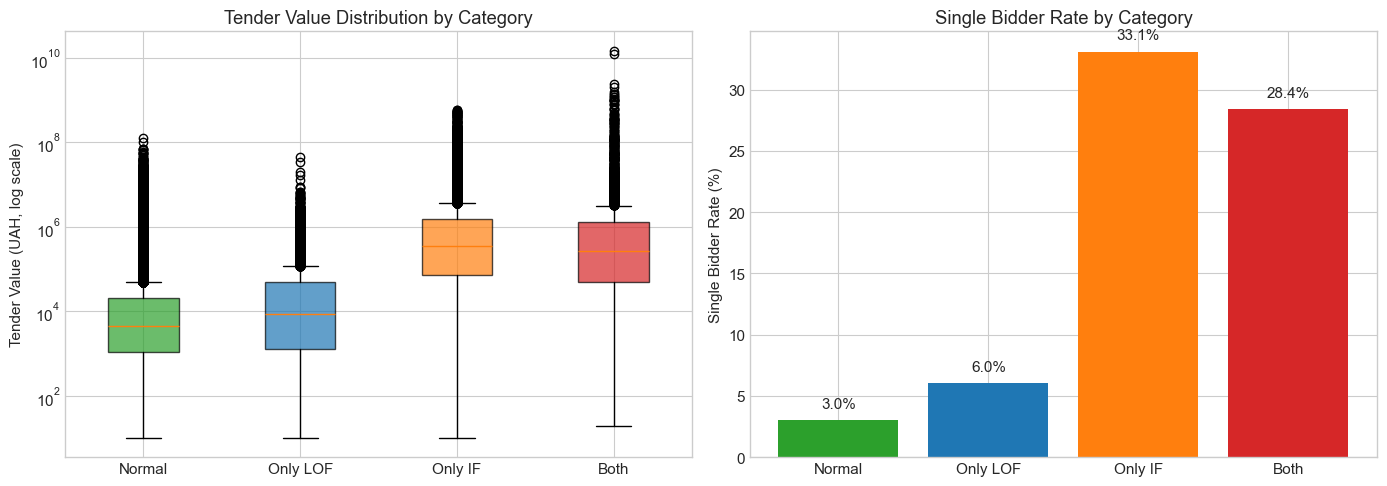

In [11]:
# Value distribution by category
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

categories = ['Normal', 'Only LOF', 'Only IF', 'Both']
colors = ['#2ca02c', '#1f77b4', '#ff7f0e', '#d62728']

# Box plot of tender values (log scale)
data_for_box = [analysis_df[analysis_df['category'] == cat]['tender_value'].values for cat in categories]
bp = axes[0].boxplot(data_for_box, tick_labels=categories, patch_artist=True)  # Fixed: labels -> tick_labels
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[0].set_yscale('log')
axes[0].set_ylabel('Tender Value (UAH, log scale)')
axes[0].set_title('Tender Value Distribution by Category')

# Single bidder rate comparison
single_rates = [analysis_df[analysis_df['category'] == cat]['is_single_bidder'].mean() * 100 for cat in categories]
bars = axes[1].bar(categories, single_rates, color=colors)
axes[1].set_ylabel('Single Bidder Rate (%)')
axes[1].set_title('Single Bidder Rate by Category')
for bar, val in zip(bars, single_rates):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{val:.1f}%', ha='center')

plt.tight_layout()
plt.savefig('../results/figures/lof/category_characteristics.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Що виявляє LOF, що IF пропускає?

In [12]:
# Only LOF anomalies
only_lof_df = analysis_df[analysis_df['category'] == 'Only LOF']
only_if_df = analysis_df[analysis_df['category'] == 'Only IF']
both_df = analysis_df[analysis_df['category'] == 'Both']
normal_df = analysis_df[analysis_df['category'] == 'Normal']

print("WHAT LOF CATCHES (that IF misses):")
print(f"  Count: {len(only_lof_df):,}")
print(f"  Mean value: {only_lof_df['tender_value'].mean():,.0f} UAH")
print(f"  Median value: {only_lof_df['tender_value'].median():,.0f} UAH")
print(f"  Single bidder rate: {only_lof_df['is_single_bidder'].mean()*100:.1f}%")
print(f"  vs Normal mean value: {normal_df['tender_value'].mean():,.0f} UAH")

print(f"\nWHAT IF CATCHES (that LOF misses):")
print(f"  Count: {len(only_if_df):,}")
print(f"  Mean value: {only_if_df['tender_value'].mean():,.0f} UAH")
print(f"  Median value: {only_if_df['tender_value'].median():,.0f} UAH")
print(f"  Single bidder rate: {only_if_df['is_single_bidder'].mean()*100:.1f}%")

print(f"\nCONSENSUS (both IF and LOF):")
print(f"  Count: {len(both_df):,}")
print(f"  Mean value: {both_df['tender_value'].mean():,.0f} UAH")
print(f"  Median value: {both_df['tender_value'].median():,.0f} UAH")
print(f"  Single bidder rate: {both_df['is_single_bidder'].mean()*100:.1f}%")

WHAT LOF CATCHES (that IF misses):
  Count: 44,240
  Mean value: 61,736 UAH
  Median value: 8,500 UAH
  Single bidder rate: 6.0%
  vs Normal mean value: 54,600 UAH

WHAT IF CATCHES (that LOF misses):
  Count: 44,240
  Mean value: 3,126,185 UAH
  Median value: 348,000 UAH
  Single bidder rate: 33.1%

CONSENSUS (both IF and LOF):
  Count: 5,760
  Mean value: 12,212,395 UAH
  Median value: 257,150 UAH
  Single bidder rate: 28.4%


In [13]:
# Procurement method breakdown
print("\nPROCUREMENT METHOD BY CATEGORY:")
method_by_cat = pd.crosstab(analysis_df['category'], analysis_df['procurement_method'], normalize='index') * 100
print(method_by_cat.round(1).to_string())


PROCUREMENT METHOD BY CATEGORY:
procurement_method  limited  open  selective
category                                    
Both                   32.8  42.0       25.2
Normal                 95.0   2.9        2.1
Only IF                15.1  57.2       27.8
Only LOF               92.0   4.6        3.5


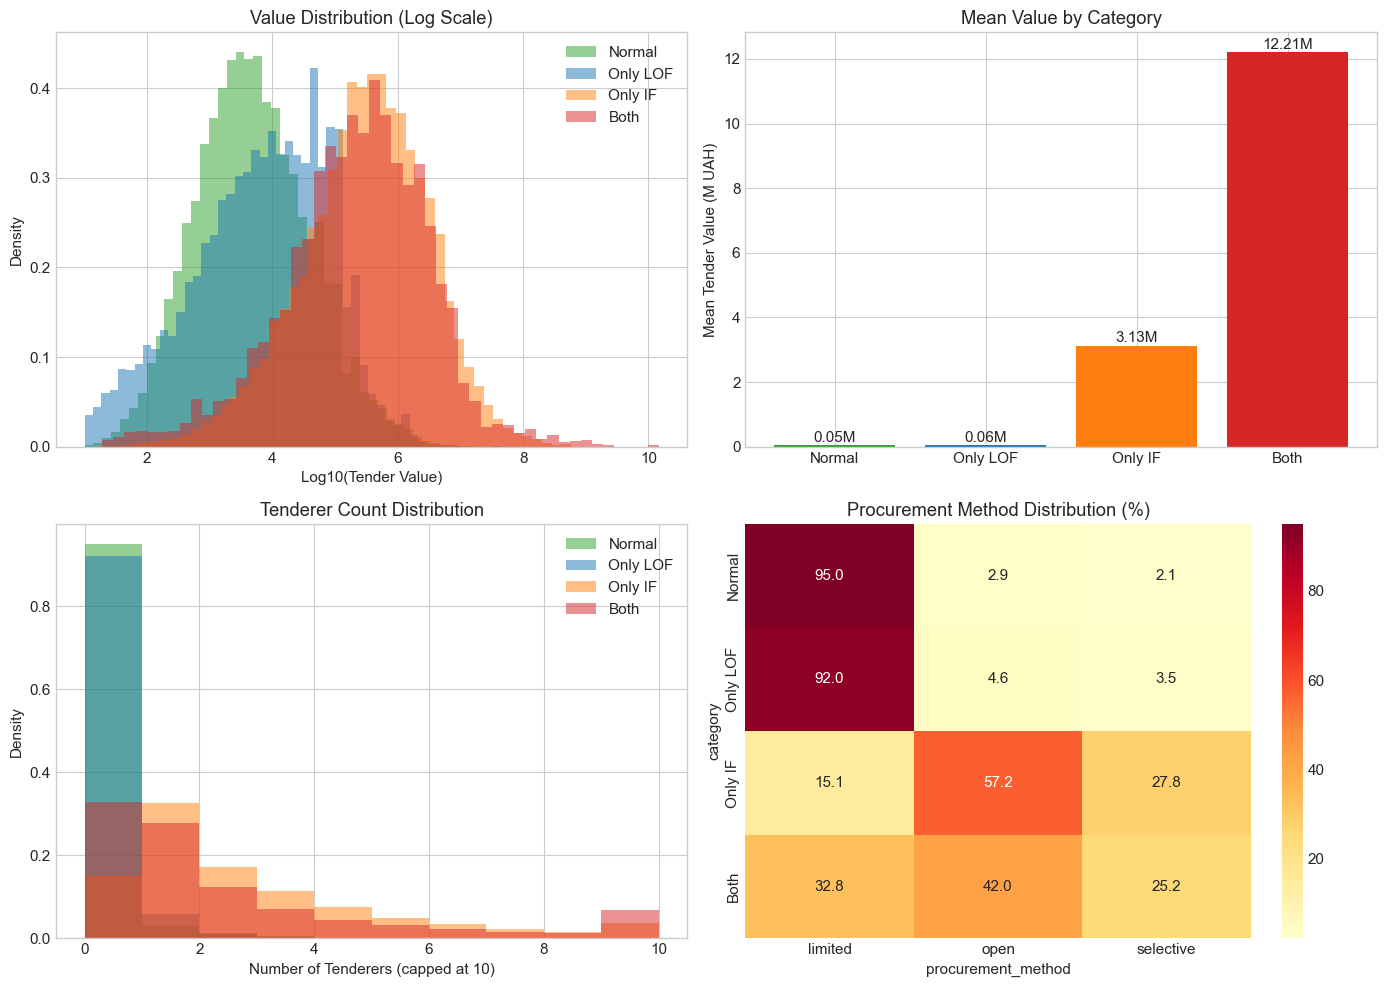

In [14]:
# Visualize what each method catches
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Value histogram comparison
ax = axes[0, 0]
for cat, color in zip(['Normal', 'Only LOF', 'Only IF', 'Both'], colors):
    data = analysis_df[analysis_df['category'] == cat]['tender_value']
    data_log = np.log10(data[data > 0])
    ax.hist(data_log, bins=50, alpha=0.5, label=cat, color=color, density=True)
ax.set_xlabel('Log10(Tender Value)')
ax.set_ylabel('Density')
ax.set_title('Value Distribution (Log Scale)')
ax.legend()

# 2. Mean value by category
ax = axes[0, 1]
mean_vals = [analysis_df[analysis_df['category'] == cat]['tender_value'].mean() / 1e6 for cat in categories]
bars = ax.bar(categories, mean_vals, color=colors)
ax.set_ylabel('Mean Tender Value (M UAH)')
ax.set_title('Mean Value by Category')
for bar, val in zip(bars, mean_vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{val:.2f}M', ha='center')

# 3. Number of tenderers distribution
ax = axes[1, 0]
for cat, color in zip(categories, colors):
    data = analysis_df[analysis_df['category'] == cat]['number_of_tenderers'].clip(upper=10)
    ax.hist(data, bins=10, alpha=0.5, label=cat, color=color, density=True)
ax.set_xlabel('Number of Tenderers (capped at 10)')
ax.set_ylabel('Density')
ax.set_title('Tenderer Count Distribution')
ax.legend()

# 4. Procurement method heatmap
ax = axes[1, 1]
method_pivot = pd.crosstab(analysis_df['category'], analysis_df['procurement_method'], normalize='index') * 100
method_pivot = method_pivot.reindex(categories)
sns.heatmap(method_pivot, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax)
ax.set_title('Procurement Method Distribution (%)')

plt.tight_layout()
plt.savefig('../results/figures/lof/method_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. LOF Parameter Sensitivity

In [15]:
# Test different n_neighbors values
n_neighbors_values = [10, 20, 50, 100]
results_by_k = {}

# Use smaller sample for parameter testing
test_sample = tenders_sample.sample(100_000, random_state=42)

for k in n_neighbors_values:
    print(f"Testing n_neighbors={k}...")
    lof_test = LOFDetector(n_neighbors=k, contamination=CONTAMINATION, features=features_extended)
    results = lof_test.fit_detect(test_sample, buyers_df=buyers, suppliers_df=suppliers)
    results_by_k[k] = results

print("\nParameter sensitivity test complete.")

Testing n_neighbors=10...
Processing 100,000 tenders...
Fitting LOF...


C:\Users\kachm\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


LOF complete! Anomalies: 5,000 (5.00%)
Testing n_neighbors=20...
Processing 100,000 tenders...
Fitting LOF...
LOF complete! Anomalies: 5,000 (5.00%)
Testing n_neighbors=50...
Processing 100,000 tenders...
Fitting LOF...
LOF complete! Anomalies: 5,000 (5.00%)
Testing n_neighbors=100...
Processing 100,000 tenders...
Fitting LOF...
LOF complete! Anomalies: 5,000 (5.00%)

Parameter sensitivity test complete.


In [16]:
# Compare results with different k values
print("\nANOMALY OVERLAP BY n_neighbors:")
for i, k1 in enumerate(n_neighbors_values):
    for k2 in n_neighbors_values[i+1:]:
        set1 = set(results_by_k[k1][results_by_k[k1]['lof_anomaly'] == 1]['tender_id'])
        set2 = set(results_by_k[k2][results_by_k[k2]['lof_anomaly'] == 1]['tender_id'])
        overlap = len(set1 & set2) / len(set1 | set2) if len(set1 | set2) > 0 else 0
        print(f"  k={k1} vs k={k2}: Jaccard = {overlap:.3f}")


ANOMALY OVERLAP BY n_neighbors:
  k=10 vs k=20: Jaccard = 0.507
  k=10 vs k=50: Jaccard = 0.276
  k=10 vs k=100: Jaccard = 0.187
  k=20 vs k=50: Jaccard = 0.455
  k=20 vs k=100: Jaccard = 0.288
  k=50 vs k=100: Jaccard = 0.555


## 9. Summary

In [17]:
print("="*60)
print("LOF ANALYSIS SUMMARY")
print("="*60)

print(f"\nDataset: {len(tenders):,} tenders")
print(f"Sample: {LOF_SAMPLE_SIZE:,} ({LOF_SAMPLE_SIZE/len(tenders)*100:.1f}%)")
print(f"Features: {total_features} extended features (same as IF)")
print(f"Parameters: n_neighbors={LOF_N_NEIGHBORS}, contamination={CONTAMINATION}")

print(f"\nIF vs LOF COMPARISON:")
print(f"  Score correlation: {score_corr:.3f}")
print(f"  Jaccard similarity: {jaccard:.3f}")
print(f"  Both flagged: {both_anomaly:,} ({both_anomaly/len(comparison)*100:.2f}%)")
print(f"  Only IF: {only_if:,} ({only_if/len(comparison)*100:.2f}%)")
print(f"  Only LOF: {only_lof:,} ({only_lof/len(comparison)*100:.2f}%)")

print(f"\nKEY INSIGHTS:")
print(f"  IF detects: Global outliers (large values, {only_if_df['tender_value'].mean()/1e6:.1f}M UAH avg)")
print(f"  LOF detects: Local outliers (medium values, {only_lof_df['tender_value'].mean()/1e6:.1f}M UAH avg)")
print(f"  Consensus: Most suspicious ({both_df['tender_value'].mean()/1e6:.1f}M UAH avg)")

print(f"\nRECOMMENDATION:")
if score_corr < 0.3:
    print(f"  LOW correlation ({score_corr:.3f}) - methods detect DIFFERENT anomalies")
    print("  Include BOTH in ensemble for comprehensive detection")
elif score_corr < 0.6:
    print(f"  MODERATE correlation ({score_corr:.3f}) - some overlap, still complementary")
else:
    print(f"  HIGH correlation ({score_corr:.3f}) - methods detect similar anomalies")

print("\n" + "="*60)

LOF ANALYSIS SUMMARY

Dataset: 12,877,960 tenders
Sample: 1,000,000 (7.8%)
Features: 19 extended features (same as IF)
Parameters: n_neighbors=20, contamination=0.05

IF vs LOF COMPARISON:
  Score correlation: 0.015
  Jaccard similarity: 0.061
  Both flagged: 5,760 (0.58%)
  Only IF: 44,240 (4.42%)
  Only LOF: 44,240 (4.42%)

KEY INSIGHTS:
  IF detects: Global outliers (large values, 3.1M UAH avg)
  LOF detects: Local outliers (medium values, 0.1M UAH avg)
  Consensus: Most suspicious (12.2M UAH avg)

RECOMMENDATION:
  LOW correlation (0.015) - methods detect DIFFERENT anomalies
  Include BOTH in ensemble for comprehensive detection



## Висновки

### LOF vs Isolation Forest:
- **Дуже низька кореляція** — методи виявляють різні типи аномалій
- **IF** → глобальні outliers (екстремальні значення, великі суми)
- **LOF** → локальні outliers (нетипові для своєї категорії/сусідства)

### Рекомендації:
1. Включити LOF в ensemble разом з IF
2. Consensus (обидва методи) — найвища впевненість
3. Only-LOF аномалії варто аналізувати окремо (локальні відхилення)

### Наступні кроки:
- DBSCAN для кластеризації (виявлення картелів)
- Ensemble scoring для об'єднання всіх методів